In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
#h = 1e-3  # Integration step size
h = 1e-4  # Integration step size
#h = 1e-5  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 12

# Set the diffusion coefficient
sigma = 1.09
print ('Lag time: ', lag_time)

Lag time:  0.01


In [3]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 144/144 [00:02<00:00, 69.83it/s]


In [4]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [5]:
# ## load the data from local folder
# import os
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# data_matrix = np.load(file_path)
# data_matrix.shape

In [6]:
!nvidia-smi

Tue Dec  3 22:53:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   51C    P5             21W /  290W |    1847MiB /   8192MiB |     29%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

Shape of data_X: (144, 10, 2)
Shape of data_Y: (144, 10, 2)
Shape of X: (1440, 2)
Shape of Y: (1440, 2)
(1007, 2)


In [8]:


checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Epoch: 1 	Training Loss: 0.684338 val loss: 0.687275
saving, val loss enhanced: 0.687274762987602 10000
Epoch: 2 	Training Loss: 0.672770 val loss: 0.682865
saving, val loss enhanced: 0.6828647938217 0.687274762987602
Epoch: 3 	Training Loss: 0.670576 val loss: 0.684760
Epoch: 4 	Training Loss: 0.663894 val loss: 0.676429
saving, val loss enhanced: 0.6764293316823046 0.6828647938217
Epoch: 5 	Training Loss: 0.656282 val loss: 0.678808
Epoch: 6 	Training Loss: 0.650803 val loss: 0.658783
saving, val loss enhanced: 0.6587833941856822 0.6764293316823046
Epoch: 7 	Training Loss: 0.644329 val loss: 0.659323
Epoch: 8 	Training Loss: 0.639757 val loss: 0.656283
saving, val loss enhanced: 0.6562834123958258 0.6587833941856822
Epoch: 9 	Training Loss: 0.634816 val loss: 0.649925
saving, val loss enhanced: 0.6499252414794169 0.6562834123958258
Epoch: 10 	Training Loss: 0.629517 val loss: 0.638906
saving, val loss enhanced: 0.6389064810696382 0.6499252414794169
Epoch: 11 	Training Loss: 0.623595 

Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4339.00iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_3ple_well.jbl
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4141.36iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003331 val loss: 0.003155
saving, val loss enhanced: 0.00315507907010636 1000000000000000.0
Epoch: 2 	Training Loss: 0.003331 val loss: 0.003155
saving, val loss enhanced: 0.0031546046605267102 0.00315507907010636
Epoch: 3 	Training Loss: 0.003330 val loss: 0.003154
saving, val loss enhanced: 0.0031541301411818316 0.0031546046605267102
Epoch: 4 	Training Loss: 0.003329 val loss: 0.003154
saving, val loss enhanced: 0.0031536558125204147 0.0031541301411818316
Epoch 1 time: 4.30 seconds
Outer Epoch 2/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4338.36iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003329 val loss: 0.003153
saving, val loss enhanced: 0.00315344313603046 0.0031536558125204147
Epoch: 2 	Training Loss: 0.003328 val loss: 0.003153
saving, val loss enhanced: 0.0031529693036018444 0.00315344313603046
Epoch: 3 	Training Loss: 0.003327 val loss: 0.003152
saving, val loss enhanced: 0.0031524958331637046 0.0031529693036018444
Epoch: 4 	Training Loss: 0.003327 val loss: 0.003152
saving, val loss enhanced: 0.003152022742430421 0.0031524958331637046
Epoch 2 time: 4.18 seconds
Outer Epoch 3/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4364.01iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003326 val loss: 0.003152
saving, val loss enhanced: 0.0031517914396187083 0.003152022742430421
Epoch: 2 	Training Loss: 0.003325 val loss: 0.003151
saving, val loss enhanced: 0.0031513190036200505 0.0031517914396187083
Epoch: 3 	Training Loss: 0.003325 val loss: 0.003151
saving, val loss enhanced: 0.003150846954973176 0.0031513190036200505
Epoch: 4 	Training Loss: 0.003324 val loss: 0.003150
saving, val loss enhanced: 0.003150375297719394 0.003150846954973176
Epoch 3 time: 4.16 seconds
Outer Epoch 4/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4328.72iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003323 val loss: 0.003150
saving, val loss enhanced: 0.003150143963265876 0.003150375297719394
Epoch: 2 	Training Loss: 0.003323 val loss: 0.003150
saving, val loss enhanced: 0.003149672961490029 0.003150143963265876
Epoch: 3 	Training Loss: 0.003322 val loss: 0.003149
saving, val loss enhanced: 0.0031492023410496124 0.003149672961490029
Epoch: 4 	Training Loss: 0.003321 val loss: 0.003149
saving, val loss enhanced: 0.00314873210465329 0.0031492023410496124
Epoch 4 time: 4.17 seconds
Outer Epoch 5/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4268.91iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003321 val loss: 0.003149
saving, val loss enhanced: 0.003148500995408001 0.00314873210465329
Epoch: 2 	Training Loss: 0.003320 val loss: 0.003148
saving, val loss enhanced: 0.0031480313983507915 0.003148500995408001
Epoch: 3 	Training Loss: 0.003319 val loss: 0.003148
saving, val loss enhanced: 0.0031475621741872202 0.0031480313983507915
Epoch: 4 	Training Loss: 0.003319 val loss: 0.003147
saving, val loss enhanced: 0.0031470933262096107 0.0031475621741872202
Epoch 5 time: 4.18 seconds
Outer Epoch 6/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4357.92iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003318 val loss: 0.003147
saving, val loss enhanced: 0.003146862600429387 0.0031470933262096107
Epoch: 2 	Training Loss: 0.003318 val loss: 0.003146
saving, val loss enhanced: 0.0031463943780575434 0.003146862600429387
Epoch: 3 	Training Loss: 0.003317 val loss: 0.003146
saving, val loss enhanced: 0.0031459265220897784 0.0031463943780575434
Epoch: 4 	Training Loss: 0.003316 val loss: 0.003145
saving, val loss enhanced: 0.003145459036448281 0.0031459265220897784
Epoch 6 time: 4.15 seconds
Outer Epoch 7/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4406.57iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003316 val loss: 0.003145
saving, val loss enhanced: 0.003145228681420057 0.003145459036448281
Epoch: 2 	Training Loss: 0.003315 val loss: 0.003145
saving, val loss enhanced: 0.0031447618116980914 0.003145228681420057
Epoch: 3 	Training Loss: 0.003314 val loss: 0.003144
saving, val loss enhanced: 0.003144295303712797 0.0031447618116980914
Epoch: 4 	Training Loss: 0.003314 val loss: 0.003144
saving, val loss enhanced: 0.003143829161808808 0.003144295303712797
Epoch 7 time: 4.12 seconds
Outer Epoch 8/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4289.47iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003313 val loss: 0.003144
saving, val loss enhanced: 0.0031435991435517347 0.003143829161808808
Epoch: 2 	Training Loss: 0.003312 val loss: 0.003143
saving, val loss enhanced: 0.0031431336107640255 0.0031435991435517347
Epoch: 3 	Training Loss: 0.003312 val loss: 0.003143
saving, val loss enhanced: 0.0031426684362399655 0.0031431336107640255
Epoch: 4 	Training Loss: 0.003311 val loss: 0.003142
saving, val loss enhanced: 0.0031422036245812197 0.0031426684362399655
Epoch 8 time: 4.23 seconds
Outer Epoch 9/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4413.45iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003310 val loss: 0.003142
saving, val loss enhanced: 0.0031419739236173815 0.0031422036245812197
Epoch: 2 	Training Loss: 0.003310 val loss: 0.003142
saving, val loss enhanced: 0.0031415097160428303 0.0031419739236173815
Epoch: 3 	Training Loss: 0.003309 val loss: 0.003141
saving, val loss enhanced: 0.0031410458639927865 0.0031415097160428303
Epoch: 4 	Training Loss: 0.003308 val loss: 0.003141
saving, val loss enhanced: 0.0031405823722231254 0.0031410458639927865
Epoch 9 time: 4.12 seconds
Outer Epoch 10/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4487.83iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003308 val loss: 0.003140
saving, val loss enhanced: 0.003140352977583614 0.0031405823722231254
Epoch: 2 	Training Loss: 0.003307 val loss: 0.003140
saving, val loss enhanced: 0.003139890085983805 0.003140352977583614
Epoch: 3 	Training Loss: 0.003306 val loss: 0.003139
saving, val loss enhanced: 0.003139427547630111 0.003139890085983805
Epoch: 4 	Training Loss: 0.003306 val loss: 0.003139
saving, val loss enhanced: 0.0031389653673694518 0.003139427547630111
Epoch 10 time: 4.08 seconds
Outer Epoch 11/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4397.00iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003305 val loss: 0.003139
saving, val loss enhanced: 0.003138736311921247 0.0031389653673694518
Epoch: 2 	Training Loss: 0.003305 val loss: 0.003138
saving, val loss enhanced: 0.0031382747285740834 0.003138736311921247
Epoch: 3 	Training Loss: 0.003304 val loss: 0.003138
saving, val loss enhanced: 0.003137813496486009 0.0031382747285740834
Epoch: 4 	Training Loss: 0.003303 val loss: 0.003137
saving, val loss enhanced: 0.003137352620558498 0.003137813496486009
Epoch 11 time: 4.12 seconds
Outer Epoch 12/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4545.88iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003303 val loss: 0.003137
saving, val loss enhanced: 0.0031371238962423055 0.003137352620558498
Epoch: 2 	Training Loss: 0.003302 val loss: 0.003137
saving, val loss enhanced: 0.003136663614448771 0.0031371238962423055
Epoch: 3 	Training Loss: 0.003301 val loss: 0.003136
saving, val loss enhanced: 0.0031362036821312544 0.003136663614448771
Epoch: 4 	Training Loss: 0.003301 val loss: 0.003136
saving, val loss enhanced: 0.0031357441042195785 0.0031362036821312544
Epoch 12 time: 4.05 seconds
Outer Epoch 13/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4349.40iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003300 val loss: 0.003136
saving, val loss enhanced: 0.0031355156658919273 0.0031357441042195785
Epoch: 2 	Training Loss: 0.003299 val loss: 0.003135
saving, val loss enhanced: 0.0031350566796883965 0.0031355156658919273
Epoch: 3 	Training Loss: 0.003299 val loss: 0.003135
saving, val loss enhanced: 0.0031345980413190703 0.0031350566796883965
Epoch: 4 	Training Loss: 0.003298 val loss: 0.003134
saving, val loss enhanced: 0.0031341397557249242 0.0031345980413190703
Epoch 13 time: 4.14 seconds
Outer Epoch 14/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4440.85iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003298 val loss: 0.003134
saving, val loss enhanced: 0.0031339116463558686 0.0031341397557249242
Epoch: 2 	Training Loss: 0.003297 val loss: 0.003133
saving, val loss enhanced: 0.003133453950222526 0.0031339116463558686
Epoch: 3 	Training Loss: 0.003296 val loss: 0.003133
saving, val loss enhanced: 0.0031329966003798607 0.003133453950222526
Epoch: 4 	Training Loss: 0.003296 val loss: 0.003133
saving, val loss enhanced: 0.0031325396017694825 0.0031329966003798607
Epoch 14 time: 4.10 seconds
Outer Epoch 15/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4456.61iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003295 val loss: 0.003132
saving, val loss enhanced: 0.003132311830558304 0.0031325396017694825
Epoch: 2 	Training Loss: 0.003294 val loss: 0.003132
saving, val loss enhanced: 0.0031318554193285144 0.003132311830558304
Epoch: 3 	Training Loss: 0.003294 val loss: 0.003131
saving, val loss enhanced: 0.003131399352920894 0.0031318554193285144
Epoch: 4 	Training Loss: 0.003293 val loss: 0.003131
saving, val loss enhanced: 0.0031309436362695004 0.003131399352920894
Epoch 15 time: 4.21 seconds
Outer Epoch 16/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4484.23iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.003293 val loss: 0.003131
saving, val loss enhanced: 0.0031307160556990335 0.0031309436362695004
Epoch: 2 	Training Loss: 0.003292 val loss: 0.003130
saving, val loss enhanced: 0.003130260924563405 0.0031307160556990335
Epoch: 3 	Training Loss: 0.003291 val loss: 0.003130
saving, val loss enhanced: 0.0031298061368484433 0.003130260924563405
Epoch: 4 	Training Loss: 0.003291 val loss: 0.003129
saving, val loss enhanced: 0.003129351697470998 0.0031298061368484433
Epoch 16 time: 4.07 seconds


In [9]:
print (solver.L_Psi.shape, solver.dPsi_X.shape, solver.data_x_train[:-1, :].shape, solver.data_y_train.shape, solver.Psi_X.shape)

torch.Size([10, 10]) torch.Size([1006, 10]) (1006, 2) (1007, 2) torch.Size([1007, 10])


(10,)
[1.00109543 1.00000481 0.96334431 0.93142651 0.88861127 0.87155013
 0.49719834 0.13384272 0.042385   0.00213204]


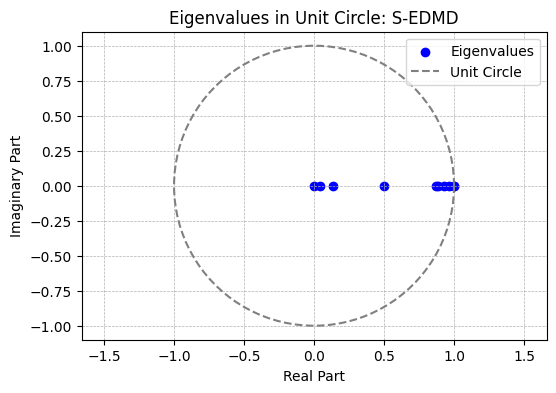

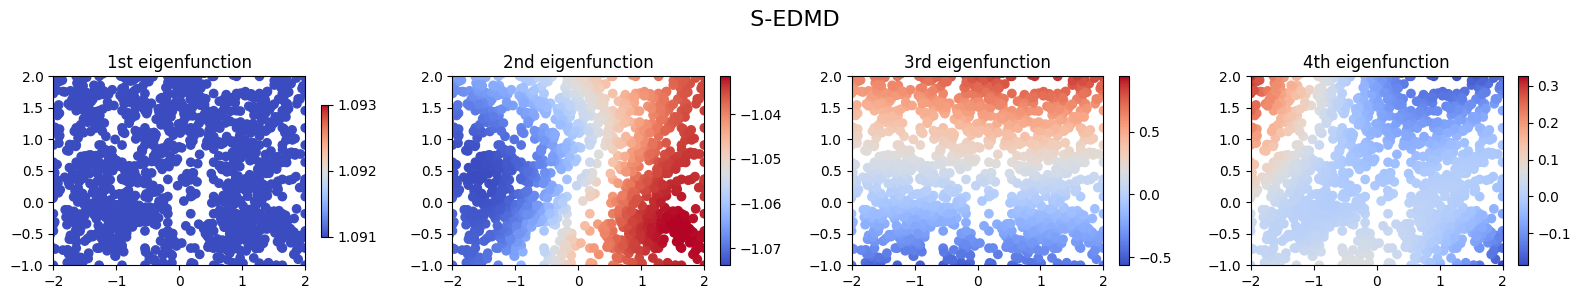

In [10]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: S-EDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' S-EDMD ', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
checkpoint_file_g= 'well2d_example_ckpt004_g.torch'

basis_function_g = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver_g = KoopmanSolverTorch_g(dic=basis_function_g, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file_g, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32)

solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_gedmd
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()


outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
#    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Precomputed SDE coefficients loaded from: a_b_example_3ple_well.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4749.15iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Outer Epoch 1/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5136.76iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5101.82iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5201.28iteration/s]


Epoch: 1 	Training Loss: 8.668093 val loss: 6.323669
saving, val loss enhanced: 6.323669448679641 1000000000000000.0
Epoch: 2 	Training Loss: 8.658239 val loss: 6.317777
saving, val loss enhanced: 6.317776695495334 6.323669448679641
Epoch: 3 	Training Loss: 8.648487 val loss: 6.311860
saving, val loss enhanced: 6.311859784040768 6.317776695495334
Epoch: 4 	Training Loss: 8.638755 val loss: 6.305935
saving, val loss enhanced: 6.305934727676247 6.311859784040768
Epoch 1 time: 9.05 seconds
Outer Epoch 2/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5133.86iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5055.49iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4925.44iteration/s]


Epoch: 1 	Training Loss: 8.615473 val loss: 6.294348
saving, val loss enhanced: 6.294347621008549 6.305934727676247
Epoch: 2 	Training Loss: 8.605794 val loss: 6.288438
saving, val loss enhanced: 6.288438120675922 6.294347621008549
Epoch: 3 	Training Loss: 8.596126 val loss: 6.282531
saving, val loss enhanced: 6.282531345032876 6.288438120675922
Epoch: 4 	Training Loss: 8.586467 val loss: 6.276628
saving, val loss enhanced: 6.276627968616637 6.282531345032876
Epoch 2 time: 9.02 seconds
Outer Epoch 3/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4953.41iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5152.87iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4909.85iteration/s]


Epoch: 1 	Training Loss: 8.563497 val loss: 6.265206
saving, val loss enhanced: 6.2652062027971045 6.276627968616637
Epoch: 2 	Training Loss: 8.553886 val loss: 6.259329
saving, val loss enhanced: 6.259329468987113 6.2652062027971045
Epoch: 3 	Training Loss: 8.544288 val loss: 6.253458
saving, val loss enhanced: 6.253458434281365 6.259329468987113
Epoch: 4 	Training Loss: 8.534699 val loss: 6.247593
saving, val loss enhanced: 6.247592773290657 6.253458434281365
Epoch 3 time: 9.09 seconds
Outer Epoch 4/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5159.13iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5065.84iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5056.57iteration/s]


Epoch: 1 	Training Loss: 8.511867 val loss: 6.236236
saving, val loss enhanced: 6.2362359438646715 6.247592773290657
Epoch: 2 	Training Loss: 8.502329 val loss: 6.230400
saving, val loss enhanced: 6.230399702516536 6.2362359438646715
Epoch: 3 	Training Loss: 8.492803 val loss: 6.224570
saving, val loss enhanced: 6.224570042734137 6.230399702516536
Epoch: 4 	Training Loss: 8.483288 val loss: 6.218746
saving, val loss enhanced: 6.218746347571407 6.224570042734137
Epoch 4 time: 9.09 seconds
Outer Epoch 5/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4985.18iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5199.43iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5146.88iteration/s]


Epoch: 1 	Training Loss: 8.460597 val loss: 6.207456
saving, val loss enhanced: 6.207456005733153 6.218746347571407
Epoch: 2 	Training Loss: 8.451133 val loss: 6.201663
saving, val loss enhanced: 6.201662622046841 6.207456005733153
Epoch: 3 	Training Loss: 8.441682 val loss: 6.195876
saving, val loss enhanced: 6.1958761296211735 6.201662622046841
Epoch: 4 	Training Loss: 8.432242 val loss: 6.190096
saving, val loss enhanced: 6.190095791490125 6.1958761296211735
Epoch 5 time: 9.14 seconds
Outer Epoch 6/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5164.33iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4921.88iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5059.55iteration/s]


Epoch: 1 	Training Loss: 8.409701 val loss: 6.178875
saving, val loss enhanced: 6.178875461833344 6.190095791490125
Epoch: 2 	Training Loss: 8.400312 val loss: 6.173126
saving, val loss enhanced: 6.173125692204355 6.178875461833344
Epoch: 3 	Training Loss: 8.390936 val loss: 6.167383
saving, val loss enhanced: 6.167382924936195 6.173125692204355
Epoch: 4 	Training Loss: 8.381571 val loss: 6.161646
saving, val loss enhanced: 6.16164636338834 6.167382924936195
Epoch 6 time: 9.07 seconds
Outer Epoch 7/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5130.54iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4785.70iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4935.21iteration/s]


Epoch: 1 	Training Loss: 8.359184 val loss: 6.150499
saving, val loss enhanced: 6.150499162033739 6.16164636338834
Epoch: 2 	Training Loss: 8.349870 val loss: 6.144793
saving, val loss enhanced: 6.144793173109717 6.150499162033739
Epoch: 3 	Training Loss: 8.340569 val loss: 6.139094
saving, val loss enhanced: 6.139094216864061 6.144793173109717
Epoch: 4 	Training Loss: 8.331279 val loss: 6.133401
saving, val loss enhanced: 6.133401462601994 6.139094216864061
Epoch 7 time: 9.20 seconds
Outer Epoch 8/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4879.43iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4836.77iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4934.18iteration/s]


Epoch: 1 	Training Loss: 8.309049 val loss: 6.122330
saving, val loss enhanced: 6.122329788996821 6.133401462601994
Epoch: 2 	Training Loss: 8.299810 val loss: 6.116667
saving, val loss enhanced: 6.116667492394137 6.122329788996821
Epoch: 3 	Training Loss: 8.290583 val loss: 6.111012
saving, val loss enhanced: 6.111012219803667 6.116667492394137
Epoch: 4 	Training Loss: 8.281368 val loss: 6.105363
saving, val loss enhanced: 6.1053631195684845 6.111012219803667
Epoch 8 time: 9.34 seconds
Outer Epoch 9/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5067.70iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5086.94iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4824.35iteration/s]


Epoch: 1 	Training Loss: 8.259298 val loss: 6.094369
saving, val loss enhanced: 6.094368704002921 6.1053631195684845
Epoch: 2 	Training Loss: 8.250133 val loss: 6.088750
saving, val loss enhanced: 6.088749881250137 6.094368704002921
Epoch: 3 	Training Loss: 8.240981 val loss: 6.083138
saving, val loss enhanced: 6.0831380520555465 6.088749881250137
Epoch: 4 	Training Loss: 8.231839 val loss: 6.077532
saving, val loss enhanced: 6.077532351619803 6.0831380520555465
Epoch 9 time: 9.11 seconds
Outer Epoch 10/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4905.76iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5043.05iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4983.54iteration/s]


Epoch: 1 	Training Loss: 8.209930 val loss: 6.066616
saving, val loss enhanced: 6.066616359245111 6.077532351619803
Epoch: 2 	Training Loss: 8.200838 val loss: 6.061041
saving, val loss enhanced: 6.061040716379489 6.066616359245111
Epoch: 3 	Training Loss: 8.191759 val loss: 6.055472
saving, val loss enhanced: 6.055472023144661 6.061040716379489
Epoch: 4 	Training Loss: 8.182691 val loss: 6.049909
saving, val loss enhanced: 6.049909406787843 6.055472023144661
Epoch 10 time: 9.15 seconds
Outer Epoch 11/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5142.82iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5061.89iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5127.59iteration/s]


Epoch: 1 	Training Loss: 8.160943 val loss: 6.039073
saving, val loss enhanced: 6.039072535349884 6.049909406787843
Epoch: 2 	Training Loss: 8.151924 val loss: 6.033540
saving, val loss enhanced: 6.033539730851658 6.039072535349884
Epoch: 3 	Training Loss: 8.142918 val loss: 6.028014
saving, val loss enhanced: 6.028013823195532 6.033539730851658
Epoch: 4 	Training Loss: 8.133922 val loss: 6.022494
saving, val loss enhanced: 6.022493935347422 6.028013823195532
Epoch 11 time: 9.08 seconds
Outer Epoch 12/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4833.59iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4833.72iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4848.82iteration/s]


Epoch: 1 	Training Loss: 8.112336 val loss: 6.011736
saving, val loss enhanced: 6.011736498469908 6.022493935347422
Epoch: 2 	Training Loss: 8.103389 val loss: 6.006246
saving, val loss enhanced: 6.006246159471109 6.011736498469908
Epoch: 3 	Training Loss: 8.094454 val loss: 6.000763
saving, val loss enhanced: 6.000762658491786 6.006246159471109
Epoch: 4 	Training Loss: 8.085531 val loss: 5.995285
saving, val loss enhanced: 5.99528511691977 6.000762658491786
Epoch 12 time: 9.34 seconds
Outer Epoch 13/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4826.33iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4987.89iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5113.05iteration/s]


Epoch: 1 	Training Loss: 8.064105 val loss: 5.984607
saving, val loss enhanced: 5.984607113461393 5.99528511691977
Epoch: 2 	Training Loss: 8.055229 val loss: 5.979159
saving, val loss enhanced: 5.979158846025142 5.984607113461393
Epoch: 3 	Training Loss: 8.046366 val loss: 5.973717
saving, val loss enhanced: 5.973717353609445 5.979158846025142
Epoch: 4 	Training Loss: 8.037513 val loss: 5.968282
saving, val loss enhanced: 5.968281758064737 5.973717353609445
Epoch 13 time: 9.26 seconds
Outer Epoch 14/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4980.04iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 5000.22iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5102.54iteration/s]


Epoch: 1 	Training Loss: 8.016248 val loss: 5.957683
saving, val loss enhanced: 5.957682930027818 5.968281758064737
Epoch: 2 	Training Loss: 8.007442 val loss: 5.952276
saving, val loss enhanced: 5.952276326077345 5.957682930027818
Epoch: 3 	Training Loss: 7.998649 val loss: 5.946876
saving, val loss enhanced: 5.946876431253557 5.952276326077345
Epoch: 4 	Training Loss: 7.989867 val loss: 5.941482
saving, val loss enhanced: 5.941482369435839 5.946876431253557
Epoch 14 time: 9.22 seconds
Outer Epoch 15/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5091.05iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 5013.71iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5044.67iteration/s]


Epoch: 1 	Training Loss: 7.968760 val loss: 5.930962
saving, val loss enhanced: 5.930962250638333 5.941482369435839
Epoch: 2 	Training Loss: 7.960025 val loss: 5.925597
saving, val loss enhanced: 5.925596892831473 5.930962250638333
Epoch: 3 	Training Loss: 7.951301 val loss: 5.920238
saving, val loss enhanced: 5.9202381762778655 5.925596892831473
Epoch: 4 	Training Loss: 7.942588 val loss: 5.914885
saving, val loss enhanced: 5.914885228101401 5.9202381762778655
Epoch 15 time: 9.11 seconds
Outer Epoch 16/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5088.27iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5043.41iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5074.75iteration/s]


Epoch: 1 	Training Loss: 7.921639 val loss: 5.904443
saving, val loss enhanced: 5.904443183802783 5.914885228101401
Epoch: 2 	Training Loss: 7.912973 val loss: 5.899119
saving, val loss enhanced: 5.8991186490673275 5.904443183802783
Epoch: 3 	Training Loss: 7.904318 val loss: 5.893801
saving, val loss enhanced: 5.893800686403106 5.8991186490673275
Epoch: 4 	Training Loss: 7.895674 val loss: 5.888488
saving, val loss enhanced: 5.888488427128487 5.893800686403106
Epoch 16 time: 9.07 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4899.36iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0


(10,)
[4.13231120e+00+0.j         1.72592388e+00+0.j
 1.00000000e+00+0.j         8.42675288e-01-0.35905605j
 8.42675288e-01+0.35905605j 8.28258072e-01+0.j
 2.29566417e-01+0.j         4.07578511e-02-0.04602937j
 4.07578511e-02+0.04602937j 3.78390567e-03+0.j        ]


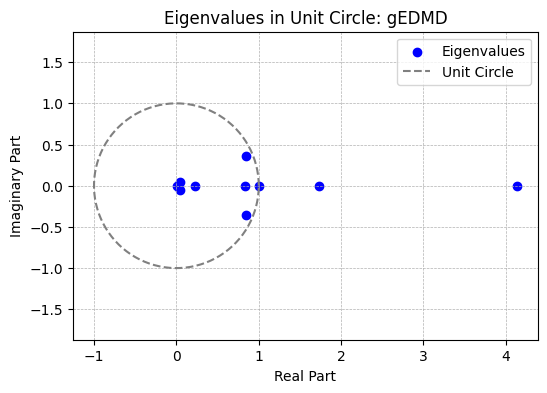

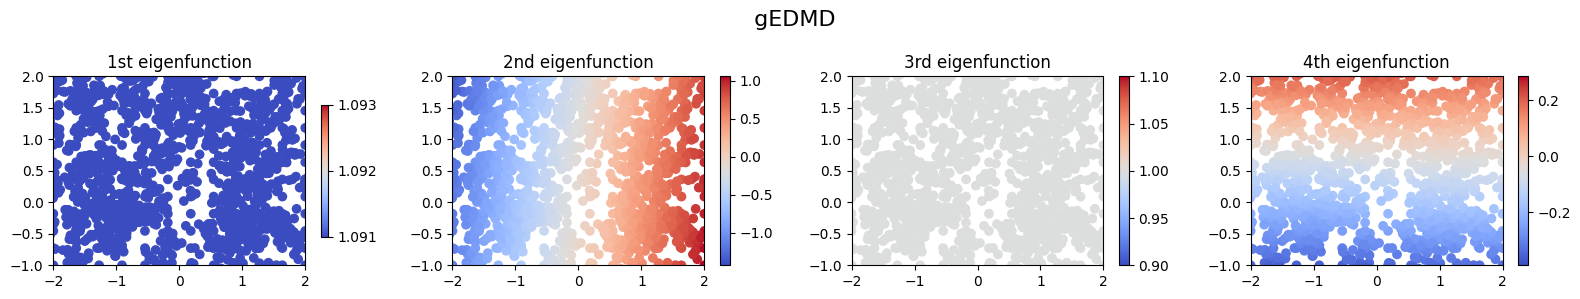

In [12]:
#computing eigenvalues of K from generator eigenvalues using exponetnt
#eigenfunctions are the same for the operator and the generator
evalues= np.exp(evalues)

# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data
# Assuming evalues is a numpy array of complex numbers

print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()
